In [1]:
# check tensorflow version

import tensorflow as tf
tf.__version__

'2.9.1'

In [2]:
# enable multi-gpu processing, if available

physical_devices = tf.config.experimental.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-08-09 15:43:24.928646: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-09 15:43:24.928723: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-14-32): /proc/driver/nvidia/version does not exist


In [30]:
# mode
YOLOV3_TINY = False

# convert
DARKNET_INPUT_WEIGHTS_PATH = "./data/yolov3.weights"
TF_YOLOV3_OUTPUT_WEIGHTS_PATH = "./checkpoints/yolov3.tf"
COCO_CLASSES = "./data/coco.names"
COCO_NUM_CLASSES = 80

# detect
SIZE = 416
TEST_IMAGE = "./data/meme.jpg"

# train
TRAIN_TFREC = "./data/train.tfrecord"
VALID_TFREC = "./data/validation.tfrecord"
RAREPLANES_CLASSES = "./data/rareplanes.names"
RAREPLANES_NUM_CLASSES = 7
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
EPOCHS = 30

In [4]:
# convert pre-trained darknet weights to yolo v3 tensorflow weights

import numpy as np
from yolov3.models import YoloV3
from yolov3.utils import load_darknet_weights

yolo = YoloV3(classes=COCO_NUM_CLASSES)
# yolo.summary()

load_darknet_weights(yolo, DARKNET_INPUT_WEIGHTS_PATH, YOLOV3_TINY)

img = np.random.random((1, 320, 320, 3)).astype(np.float32)
output = yolo(img)

yolo.save_weights(TF_YOLOV3_OUTPUT_WEIGHTS_PATH)

2022-08-09 15:37:19.581390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-08-09 15:43:25.463031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


time: 0.5281431674957275
detections:
	cup, 0.9980729818344116, [0.14266217 0.52777606 0.27184254 0.65748256]
	person, 0.9976975321769714, [0.28982913 0.09854648 0.95846486 0.9202168 ]
	laptop, 0.9599869847297668, [-0.01710653  0.3949369   0.5229728   0.7962775 ]
	apple, 0.9081623554229736, [0.13114463 0.77143586 0.22893356 0.90729535]
	cell phone, 0.7321367263793945, [0.18850096 0.87569416 0.33501852 0.9422209 ]
	clock, 0.6700012683868408, [0.4010809  0.21244611 0.49267417 0.35021502]


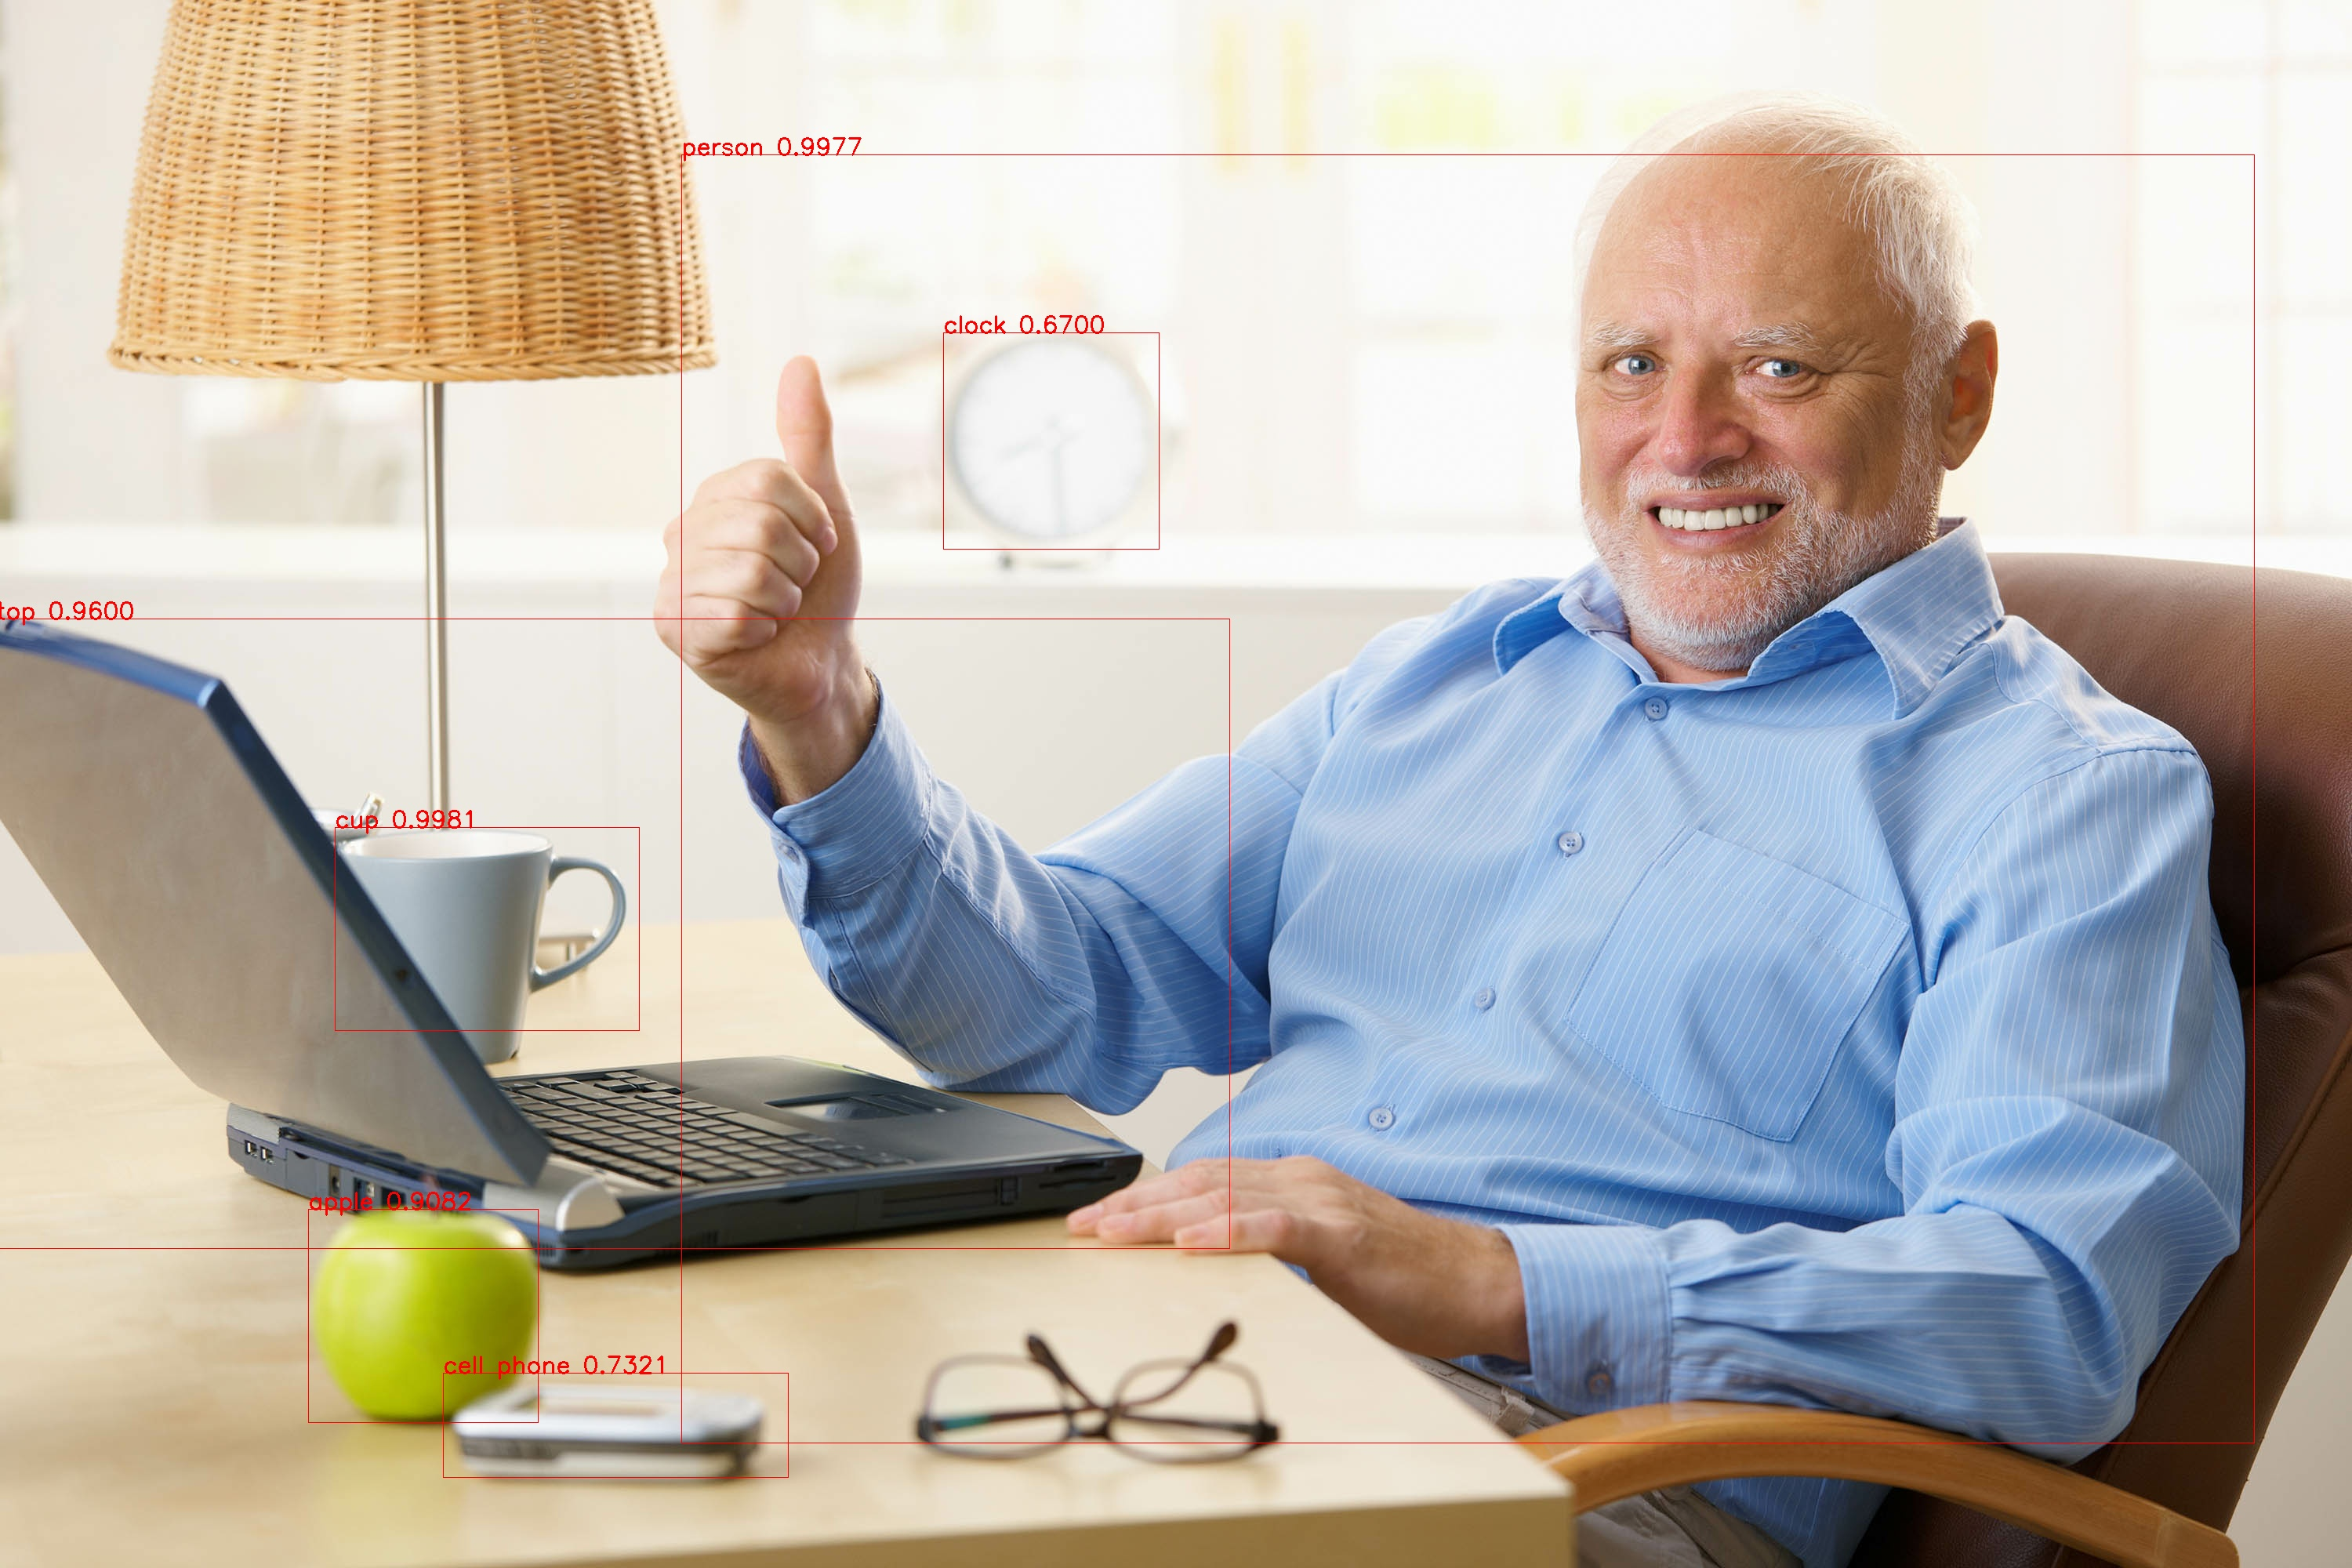

In [4]:
# initialize model with darknet weights and make prediction

import time
import numpy as np
import cv2
from IPython.display import Image, display
from yolov3.models import YoloV3
from yolov3.dataset import transform_images
from yolov3.utils import draw_outputs

yolo = YoloV3(classes=COCO_NUM_CLASSES)

yolo.load_weights(TF_YOLOV3_OUTPUT_WEIGHTS_PATH).expect_partial()

class_names = [c.strip() for c in open(COCO_CLASSES).readlines()]

img_raw = tf.image.decode_image(open(TEST_IMAGE, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, SIZE)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()

print('time: {}'.format(t2 - t1))

print('detections:')

for i in range(nums[0]):
    print('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                np.array(scores[0][i]),
                                np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

labels:
	large_civil_transport_utility, 1, [0.14827946 0.5324562  0.44237342 0.7381901 ]
	large_civil_transport_utility, 1, [0.1937783  0.80017406 0.4865535  0.99865454]


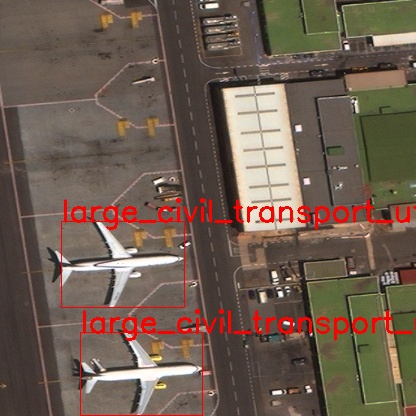

In [18]:
# visualize rareplanes sample from tfrecords

from yolov3.dataset import load_rareplanes_tfrecord_dataset

class_names = [c.strip() for c in open(RAREPLANES_CLASSES).readlines()]

train_dataset = load_rareplanes_tfrecord_dataset(TRAIN_TFREC, SIZE)
train_dataset = train_dataset.shuffle(512)

for image, labels in train_dataset.take(1):
    
    boxes = []
    scores = []
    classes = []
    
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
        
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    print("labels:")
    for i in range(nums[0]):
        print(
            "\t{}, {}, {}".format(
                class_names[int(classes[0][i])],
                np.array(scores[0][i]),
                np.array(boxes[0][i]),
            )
        )

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=600))

In [24]:
# set up model for training

from yolov3.models import YoloV3, YoloLoss, yolo_anchors, yolo_anchor_masks
from yolov3.utils import freeze_all

def setup_model():
    model = YoloV3(SIZE, training=True, classes=RAREPLANES_NUM_CLASSES)
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks
    
    model_pretrained = YoloV3(SIZE, 
                              training=True, 
                              classes=COCO_NUM_CLASSES or RAREPLANES_NUM_CLASSES)
    
    model_pretrained.load_weights(TF_YOLOV3_OUTPUT_WEIGHTS_PATH)
    
    model.get_layer("yolo_darknet").set_weights(
        model_pretrained.get_layer("yolo_darknet").get_weights()
    )
    freeze_all(model.get_layer("yolo_darknet"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = [YoloLoss(anchors[mask], classes=RAREPLANES_NUM_CLASSES) for mask in anchor_masks]

    model.compile(optimizer=optimizer, loss=loss, run_eagerly=False)    

    return model, optimizer, loss, anchors, anchor_masks

In [25]:
model, optimizer, loss, anchors, anchor_masks = setup_model()

In [29]:
import yolov3.dataset as dataset

# prepare train dataset
train_dataset = dataset.load_rareplanes_tfrecord_dataset(TRAIN_TFREC, SIZE)
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(
    lambda x, y: (
        dataset.transform_images(x, SIZE),
        dataset.transform_targets(y, anchors, anchor_masks, SIZE),
    )
)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# prepare validation dataset
val_dataset = dataset.load_rareplanes_tfrecord_dataset(VALID_TFREC, SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.map(
    lambda x, y: (
        dataset.transform_images(x, SIZE),
        dataset.transform_targets(y, anchors, anchor_masks, SIZE),
    )
)

In [32]:
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard,
)

callbacks = [
    ReduceLROnPlateau(verbose=1),
    EarlyStopping(patience=3, verbose=1),
    ModelCheckpoint(
        "checkpoints/yolov3_train_{epoch}.tf", verbose=1, save_weights_only=True
    ),
    TensorBoard(log_dir="logs"),
]

start_time = time.time()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_dataset,
)
end_time = time.time() - start_time

print(f"Total Training Time: {end_time}")

Epoch 1/30
Instructions for updating:
Use fn_output_signature instead
      6/Unknown - 72s 9s/step - loss: 8656.0078 - yolo_output_0_loss: 625.7795 - yolo_output_1_loss: 2016.6613 - yolo_output_2_loss: 6002.9214 

KeyboardInterrupt: 